In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [4]:
print("IT'S ALIVE!!")

IT'S ALIVE!!


In [5]:
lb = pd.read_csv('../input/tpsmay22publiclb/tabular-playground-series-may-2022-publicleaderboard.csv')

In [6]:
lb

TeamId            TeamName       SubmissionDate    Score
0     8559248            The Team  2022-05-28 20:52:58  0.99836
1     8561214          Joe Cooper  2022-05-26 13:49:33  0.99830
2     8561072          Aman Singh  2022-05-29 11:39:21  0.99830
3     8561784            Outatime  2022-05-31 13:45:36  0.99830
4     8566621  Christophe Nicault  2022-05-28 07:42:46  0.99829
...       ...                 ...                  ...      ...
1137  8647590        Arqum Ashraf  2022-05-19 19:33:40  0.48901
1138  8658517        RAKSHITHA BS  2022-05-21 14:24:28  0.48808
1139  8662123       Yin Keong Tan  2022-05-30 06:53:21  0.48499
1140  8659033         Kapil Warke  2022-05-21 15:22:36  0.11386
1141  8564396         Tarun Yadav  2022-05-02 09:52:03  0.08412

[1142 rows x 4 columns]

What's the biggest plateaus in this LB?

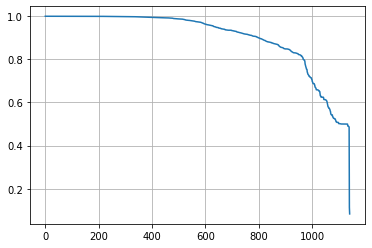

In [16]:
lb.Score.plot()
plt.grid()

Soo, around 420 guys are very close to 1.0, then we get the 600 - 850 range of runner ups, then the guys who didn't do enough and the rest is just 0.

To get in top 10% we need to get LB score of:

In [24]:
lb.Score.quantile(.901)

0.99823

In [30]:
def percentile_from_score(sc):
    return sum(lb.Score < sc) / len(lb.Score)

In [32]:
percentile_from_score(.99)

0.5910683012259195

Damn.

In [77]:
train_raw = pd.read_csv('../input/tabular-playground-series-may-2022/train.csv',index_col = 0)
test_raw = pd.read_csv('../input/tabular-playground-series-may-2022/test.csv', index_col = 0)

In [78]:
sample_sub = pd.read_csv('../input/tabular-playground-series-may-2022/sample_submission.csv')

Define and check the metric (ROC):

In [79]:
from sklearn.metrics import roc_auc_score
def metric(y_true, y_pred):
#     y_pred = np.array(y_pred,'float32')
#     print(set(y_true) | {0.,1.}) == {0., 1.}
    assert min(y_pred) >= 0 and max(y_pred) <= 1.
    return roc_auc_score(y_true, y_pred)

In [80]:
assert metric([1,0], [1,0]) == 1
assert metric([1,0], [0,1]) == 0
assert metric([1,0], [0.5,0.5]) == .5

Split

In [103]:
from sklearn.model_selection import train_test_split
x_train_full, y_train_full = train_raw.drop('target',axis=1), train_raw.target
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full, y_train_full, random_state=42,
)
df_train = pd.concat([x_train, y_train],axis=1)
df_valid = pd.concat([x_valid, y_valid],axis=1)

Baseline predictions:

In [91]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(x_train, y_train)
y_pred = dummy_clf.predict(x_valid)
print("BASELINE ROC:",metric(y_true = y_valid, y_pred = y_pred))

BASELINE ROC: 0.49989525243360056


Is there class imba?

In [95]:
y_train.value_counts(normalize=True)

0    0.513456
1    0.486544
Name: target, dtype: float64

Nope, not even a whiff of imbalance. No need to use imba lib.

What kind of columns do we have (cat/num)?

In [102]:
x_train.dtypes

f_00    float64
f_01    float64
f_02    float64
f_03    float64
f_04    float64
f_05    float64
f_06    float64
f_07      int64
f_08      int64
f_09      int64
f_10      int64
f_11      int64
f_12      int64
f_13      int64
f_14      int64
f_15      int64
f_16      int64
f_17      int64
f_18      int64
f_19    float64
f_20    float64
f_21    float64
f_22    float64
f_23    float64
f_24    float64
f_25    float64
f_26    float64
f_27     object
f_28    float64
f_29      int64
f_30      int64
dtype: object

One object, that will need some kind of encoding + int columns (these we will have to decide about) + floats. 


First:
1. If floats do not occur discretely, we can assume they are just continuous features. 
2. If floats have a clipped upper limit, we will have to take that into account. 

<Figure size 1080x1080 with 0 Axes>

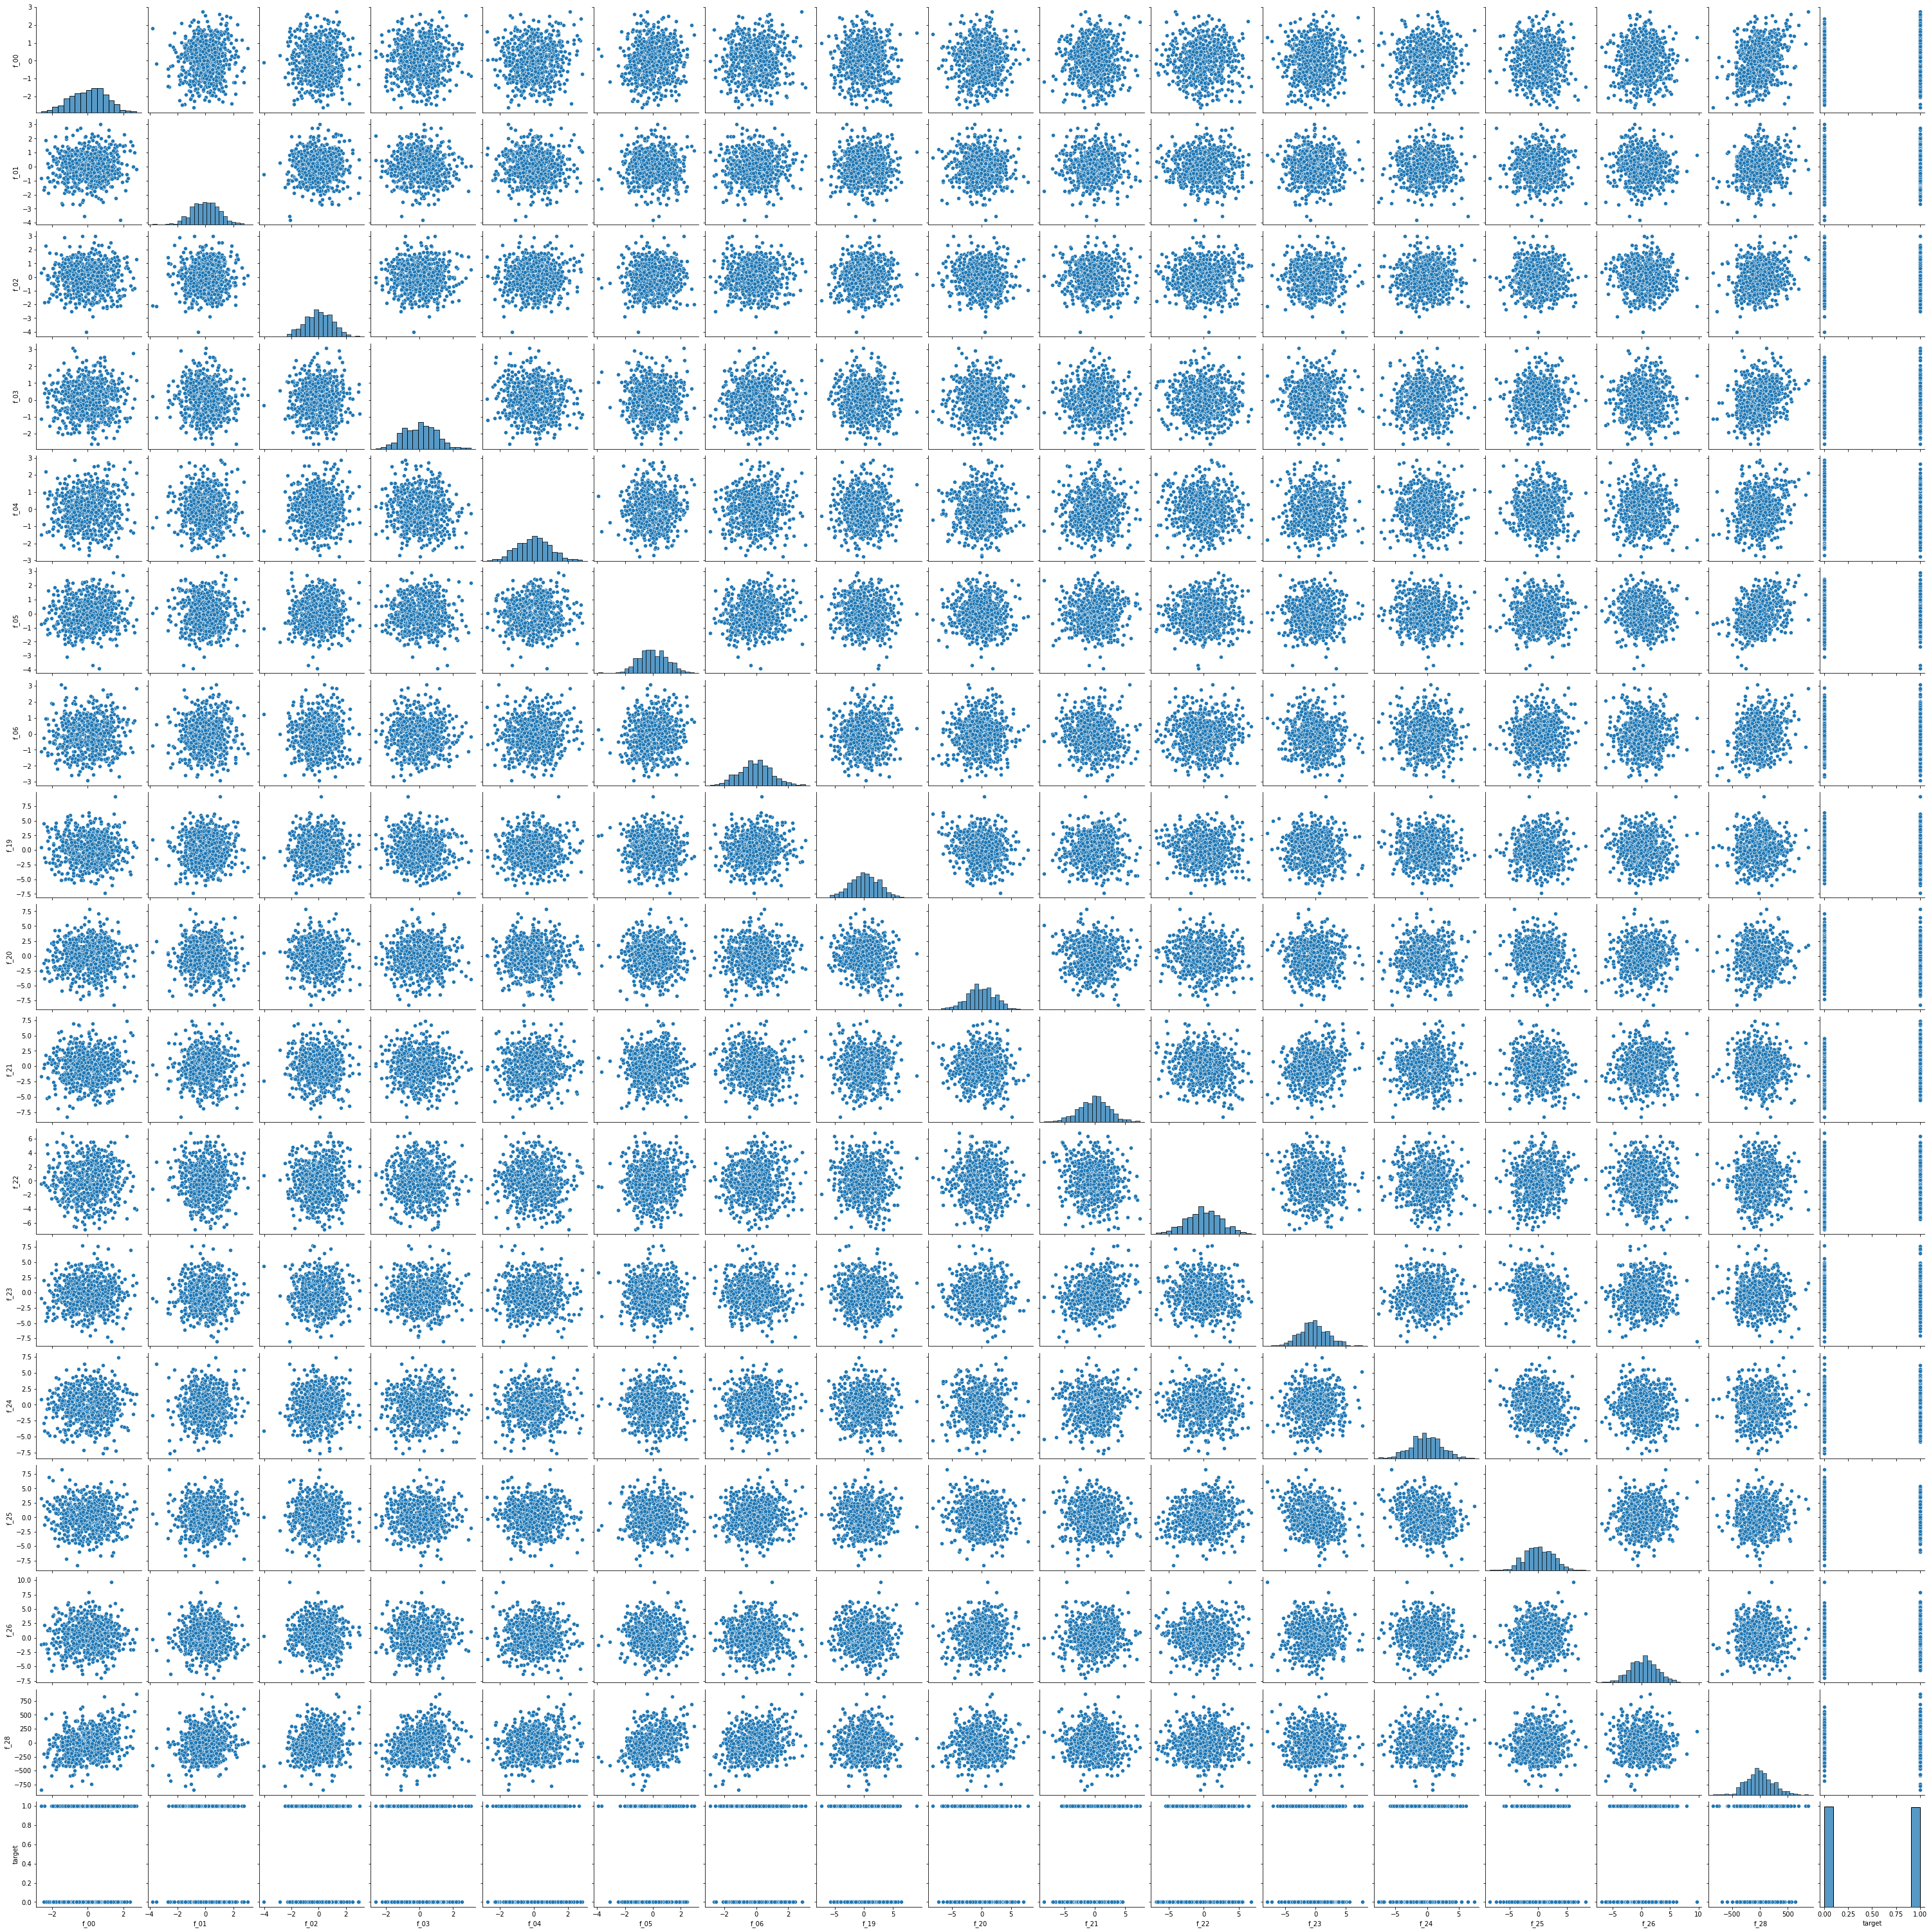

In [112]:
#Grab a sample
samp = df_train.sample(frac=.001)
samp = pd.concat([samp.select_dtypes('float64'), samp.target],axis=1)

import seaborn as sns

plt.figure(figsize=(15,15))
sns.pairplot(samp)

Now we know. All floats have a smooth gaussian-like shape, no bumps, no clips. Next.

Int columns. 
For these, we will need to first count cardinality.   
If cardinality is low <= 3, then we go one-hot route.   
If it's medium <= 300, we go target encoding route,   
If it's higher than that, then:  
- if there is a tail of very rare categories, group them into one and start from cond 1.  
- else use hashing or manually find a way to convert into good categorical col.  
- else drop.  

In [115]:
#Grab a sample
samp = df_train.sample(frac=.01)
samp = pd.concat([samp.select_dtypes('int64'), samp.target],axis=1)

# import seaborn as sns

# plt.figure(figsize=(15,15))
# sns.pairplot(samp)
samp.describe()

f_07         f_08         f_09         f_10         f_11  \
count  6750.000000  6750.000000  6750.000000  6750.000000  6750.000000   
mean      2.045926     2.042370     2.353037     2.180889     1.821778   
std       1.665446     1.597704     1.645034     1.635296     1.562573   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     1.000000     1.000000     1.000000     1.000000   
50%       2.000000     2.000000     2.000000     2.000000     2.000000   
75%       3.000000     3.000000     3.000000     3.000000     3.000000   
max      11.000000    10.000000    10.000000    12.000000    13.000000   

              f_12         f_13         f_14         f_15         f_16  \
count  6750.000000  6750.000000  6750.000000  6750.000000  6750.000000   
mean      2.836444     2.242815     1.528444     2.105630     2.109481   
std       1.772321     1.550982     1.367231     1.566224     1.568607   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       2.000000     1.000000     0.000000     1.000000     1.000000   
50%       3.000000     2.000000     1.000000     2.000000     2.000000   
75%       4.000000     3.000000     2.000000     3.000000     3.000000   
max      10.000000    10.000000    10.000000    11.000000    11.000000   

              f_17         f_18         f_29         f_30       target  \
count  6750.000000  6750.000000  6750.000000  6750.000000  6750.000000   
mean      1.832148     2.083111     0.349481     0.981778     0.489778   
std       1.473569     1.606051     0.476842     0.820608     0.499933   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     1.000000     0.000000     0.000000     0.000000   
50%       2.000000     2.000000     0.000000     1.000000     0.000000   
75%       3.000000     3.000000     1.000000     2.000000     1.000000   
max      11.000000    10.000000     1.000000     2.000000     1.000000   

            target  
count  6750.000000  
mean      0.489778  
std       0.499933  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

In [69]:
df_raw = pd.concat([train_raw, test_raw], axis=0)

In [70]:
df_raw

id      f_00      f_01      f_02      f_03      f_04      f_05  \
0             0 -1.373246  0.238887 -0.243376  0.567405 -0.647715  0.839326   
1             1  1.697021 -1.710322 -2.230332 -0.545661  1.113173 -1.552175   
2             2  1.681726  0.616746 -1.027689  0.810492 -0.609086  0.113965   
3             3 -0.118172 -0.587835 -0.804638  2.086822  0.371005 -0.128831   
4             4  1.148481 -0.176567 -0.664871 -1.101343  0.467875  0.500117   
...         ...       ...       ...       ...       ...       ...       ...   
699995  1599995  0.640110  0.897808 -0.523956  1.563760 -0.092281 -0.610867   
699996  1599996 -0.191771 -0.035246 -0.118533  0.584750  2.126977  0.568659   
699997  1599997 -0.331704 -0.328845 -1.185503  1.022128 -0.483099 -0.107146   
699998  1599998 -2.031073 -1.238398  0.964699 -1.045950  0.906064  0.634301   
699999  1599999 -0.085906 -0.002124  2.227375  0.217145  3.179153 -1.660188   

            f_06  f_07  f_08  ...      f_22      f_23      f_24      f_25  \
0       0.113133     1     5  ... -2.540739  0.766952 -2.730628 -0.208177   
1       0.447825     1     3  ...  2.278315 -0.633658 -1.217077 -3.782194   
2      -0.708660     1     0  ... -1.385775 -0.520558 -0.009121  2.788536   
3      -0.282575     3     2  ...  0.572594 -1.653213  1.686035 -2.533098   
4       0.407515     3     3  ... -3.912929 -1.430366  2.127649 -3.306784   
...          ...   ...   ...  ...       ...       ...       ...       ...   
699995  0.535426     0     1  ...  1.122867  0.518110  1.243837  0.575111   
699996 -0.052663     4     3  ...  1.384682 -1.135740  2.982713 -1.511760   
699997 -0.968281     1     1  ... -1.845266  1.096011 -2.734508 -4.885955   
699998 -0.707474     5     1  ... -1.696606  1.018995  1.973697 -0.353068   
699999  0.891989     0     3  ... -4.325318 -5.017221  0.251268 -3.236026   

            f_26        f_27        f_28  f_29  f_30  target  
0       1.363402  ABABDADBAB   67.609153     0     0     0.0  
1      -0.058316  ACACCADCEB  377.096415     0     0     1.0  
2      -3.703488  AAAEABCKAD -195.599702     0     2     1.0  
3      -0.608601  BDBBAACBCB  210.826205     0     0     1.0  
4       4.371371  BDBCBBCHFE -217.211798     0     1     1.0  
...          ...         ...         ...   ...   ...     ...  
699995  0.076372  BCBCEBHMCD  204.186539     0     0     NaN  
699996  2.225218  BAABCADQFC  -97.694591     0     2     NaN  
699997 -2.248739  AAAJCBGQBA  130.622745     1     0     NaN  
699998 -3.333449  BCBBCABNDE -364.625148     0     0     NaN  
699999 -0.362070  AFBEBACHFF -155.417342     0     1     NaN  

[1600000 rows x 33 columns]